In [1]:
from transformers import PaliGemmaForConditionalGeneration,PaliGemmaProcessor,SiglipModel
from safetensors.torch import load_file
from PIL import Image

import re
import torch
from PIL import ImageDraw, ImageFont

torch.set_grad_enabled(False)

/Users/bitan/Desktop/medgemma/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch.autograd.grad_mode.set_grad_enabled(mode=False)

In [2]:
def draw_paligemma_boxes(image, model_output, width=3):
    img = image.copy()
    draw = ImageDraw.Draw(img)
    W, H = img.size
    colors = {
        "molar": "red",
        "premolar": "blue", 
        "canine": "green",
        "incisor": "orange",
        "unknown": "grey"
    }
    pattern = r"<loc(\d{4})><loc(\d{4})><loc(\d{4})><loc(\d{4})>\s*([^;<]+)"
    matches = re.findall(pattern, model_output)
    for ymin, xmin, ymax, xmax, label in matches:
        ymin = int(ymin)
        xmin = int(xmin)
        ymax = int(ymax)
        xmax = int(xmax)
        x1 = xmin / 1023 * W
        y1 = ymin / 1023 * H
        x2 = xmax / 1023 * W
        y2 = ymax / 1023 * H
        label_lower = label.strip().lower()
        color = colors.get(label_lower, "grey")
        draw.rectangle([x1, y1, x2, y2], outline=color, width=width)
        draw.text((x1, y1 - 10), label.strip(), fill=color)
    return img

In [66]:
model = PaliGemmaForConditionalGeneration.from_pretrained("justacoderwhocodes/paligemma-dental-finetune",dtype=torch.bfloat16) #
processor = PaliGemmaProcessor.from_pretrained("google/paligemma2-3b-pt-448",dtype=torch.bfloat16)
medsiglip = SiglipModel.from_pretrained("google/medsiglip-448",dtype=torch.bfloat16)

Loading weights: 100%|██████████| 888/888 [00:03<00:00, 246.49it/s, Materializing param=vision_model.post_layernorm.weight]                      


In [67]:
# model = PaliGemmaForConditionalGeneration.from_pretrained("trained_1000_steps",dtype=torch.bfloat16)

In [68]:
# medsiglip_state_dict = medsiglip.vision_model.state_dict()
# head_keys = [key for key in medsiglip_state_dict.keys() if 'head' in key]
# filtered_state_dict_no_head = {
#     k: v for k, v in medsiglip_state_dict.items() 
#     if not k.startswith("head.")
# }

In [69]:
# model.model.vision_tower.vision_model.load_state_dict(filtered_state_dict_no_head, strict=True)

In [70]:
model = model.to("mps")
model = model.eval()

In [85]:
image = Image.open("dataset_mixed_bbox/panoramic_img16.jpg")
prompt = "<image><bos>detect canine; detect incisor; detect molar; detect premolar;"

In [86]:
inputs = processor(images=image,text=prompt,return_tensors="pt")

In [87]:
for k in inputs:
    inputs[k] = inputs[k].to("mps")

In [91]:
temp = model.generate(**inputs,max_new_tokens=384)
result = processor.decode(temp,skip_special_tokens=False)

In [92]:
print(result[0].replace("<image>",""))

<bos><bos>detect canine; detect incisor; detect molar; detect premolar;
<loc0404><loc0151><loc0457><loc0208> molar; <loc0430><loc0177><loc0513><loc0253> molar; <loc0443><loc0226><loc0536><loc0286> molar; <loc0443><loc0281><loc0541><loc0325> molar; <loc0441><loc0322><loc0553><loc0361> premolar; <loc0461><loc0358><loc0557><loc0395> premolar; <loc0417><loc0392><loc0565><loc0438> canine; <loc0488><loc0425><loc0567><loc0461> incisor; <loc0468><loc0469><loc0573><loc0507> incisor; <loc0451><loc0517><loc0573><loc0570> incisor; <loc0452><loc0568><loc0571><loc0609> incisor; <loc0404><loc0608><loc0534><loc0663> canine; <loc0463><loc0640><loc0560><loc0676> premolar; <loc0470><loc0671><loc0565><loc0718> premolar; <loc0474><loc0715><loc0560><loc0761> molar; <loc0451><loc0748><loc0552><loc0799> molar; <loc0417><loc0783><loc0510><loc0844> molar; <loc0546><loc0814><loc0617><loc0873> molar; <loc0547><loc0754><loc0649><loc0838> molar; <loc0565><loc0696><loc0675><loc0777> molar; <loc0587><loc0648><loc0698

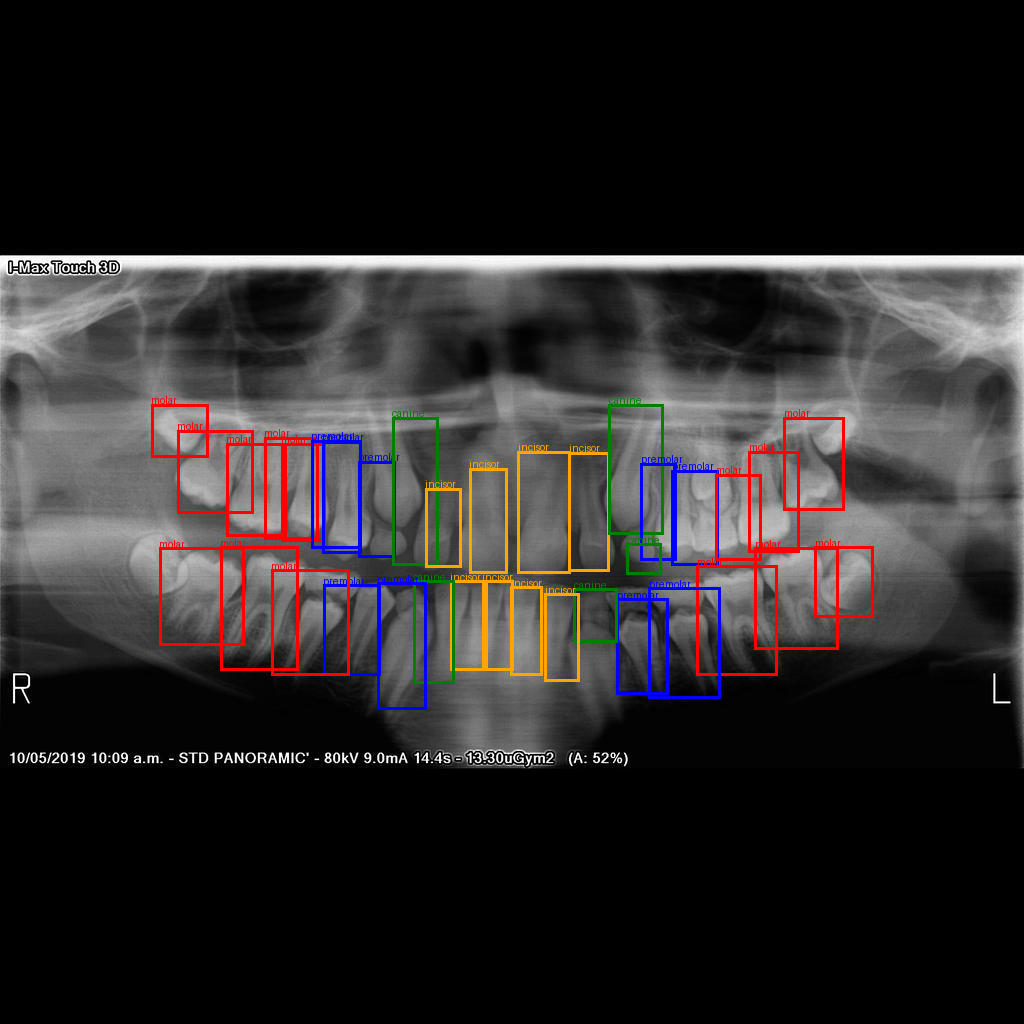

In [93]:
draw_paligemma_boxes(image,result[0])

From mixed trained model (panoramic_img128)

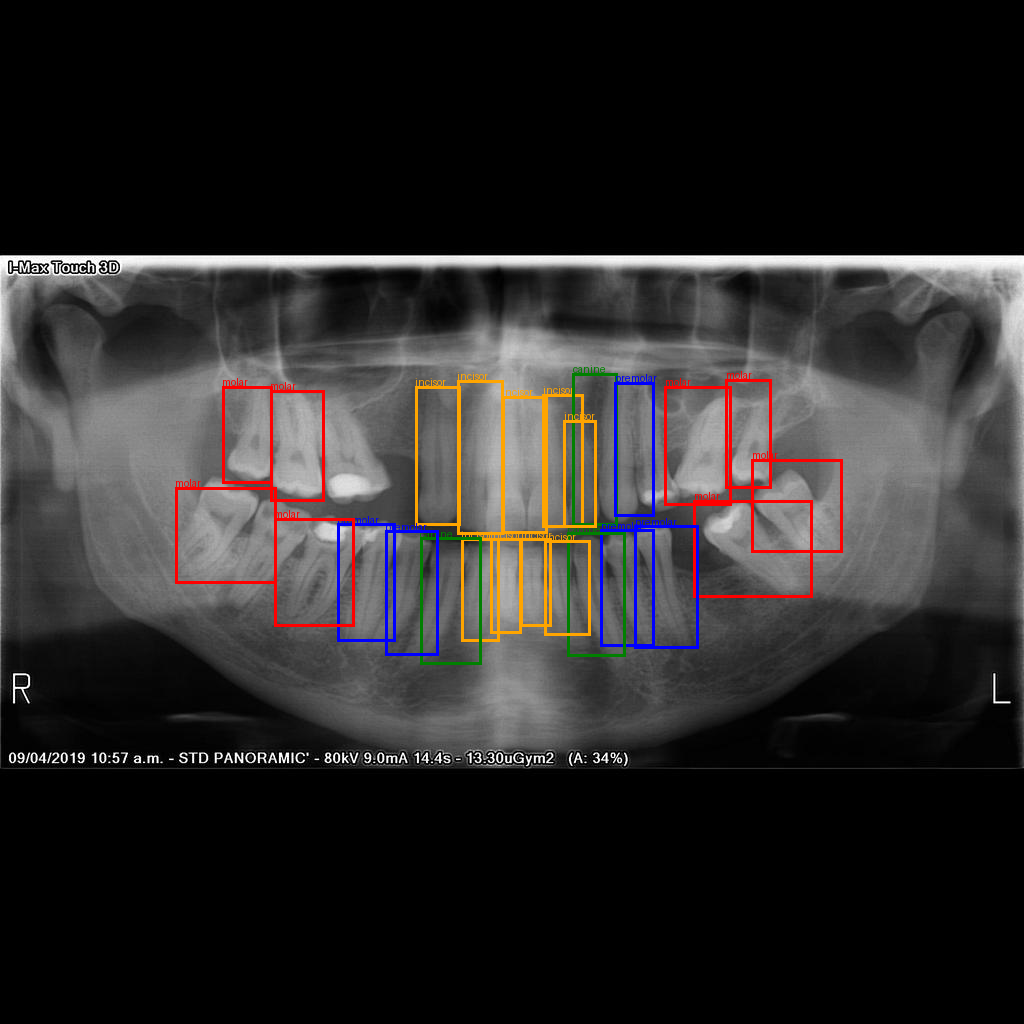

In [ ]:
draw_paligemma_boxes(image,result[0]) #img128